## Machine Learning

### Cross_ Validation with Linear Regression

#### A. Experiments to Understand Overfitting

In [1]:
# import all libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import re

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import scale
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline

import warnings # supress warnings
warnings.filterwarnings('ignore')

In [2]:
# importing data
Milk_Bovine = pd.read_csv('Milk_Bovine.csv')
Milk_Bovine.head()

,Country,Year,Milk Produced,Number of Dairy Cows
0,Belgium,2011,3151.00,510.65
1,Bulgaria,2011,1126.00,313.18
2,Czechia,2011,2735.93,374.07
3,Denmark,2011,4879.50,579.00
4,Germany,2011,30301.36,4190.10


In [3]:
# number of observations 
len(Milk_Bovine.index)

297

For the first experiment, regression with only one feature by filtering the data so it only contains `Milk Produced` and `Number of Dairy Cows`.

In [4]:
# filter only `Milk Produced` and `Number of Dairy Cows`.
df = Milk_Bovine.loc[:, ['Milk Produced', 'Number of Dairy Cows']]
df.head()

,Milk Produced,Number of Dairy Cows
0,3151.00,510.65
1,1126.00,313.18
2,2735.93,374.07
3,4879.50,579.00
4,30301.36,4190.10


In [5]:
# recaling the variables (both)
df_columns = df.columns
scaler = MinMaxScaler()
df = scaler.fit_transform(df)

# rename columns (since now its an np array)
df = pd.DataFrame(df)
df.columns = df_columns

df.head()

,Milk Produced,Number of Dairy Cows
0,0.094084,0.117670
1,0.032963,0.071637
2,0.081556,0.085831
3,0.146256,0.133603
4,0.913569,0.975388


<AxesSubplot:xlabel='Number of Dairy Cows', ylabel='Milk Produced'>

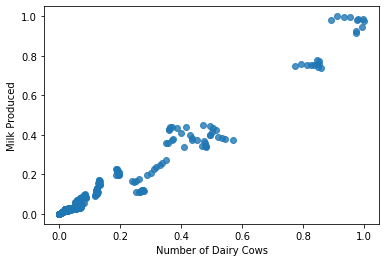

In [6]:
# visualise Number of cows- Milk produced relationship
sns.regplot(x="Number of Dairy Cows", y="Milk Produced", data=df, fit_reg=False)

In [7]:
# split into train and test
df_train, df_test = train_test_split(df, 
                                     train_size = 0.7, 
                                     test_size = 0.3, 
                                     random_state = 10)
print(len(df_train))
print(len(df_test))

207
90


In [8]:
# split into X and y for both train and test sets
# reshaping is required since sklearn requires the data to be in shape
# (n, 1), not as a series of shape (n, )
X_train = df_train['Number of Dairy Cows']
X_train = X_train.values.reshape(-1, 1)
y_train = df_train['Milk Produced']

X_test = df_test['Number of Dairy Cows']
X_test = X_test.values.reshape(-1, 1)
y_test = df_test['Milk Produced']

#### Polynomial Regression

In [9]:
len(X_train)

207

I want to predict the y labels for both train and test sets

In [10]:
# fit multiple polynomial features
degrees = [1, 2, 3, 6, 10, 20]

# initialise y_train_pred and y_test_pred matrices to store the train and test predictions
# each row is a data point, each column a prediction using a polynomial of some degree
y_train_pred = np.zeros((len(X_train), len(degrees)))
y_test_pred = np.zeros((len(X_test), len(degrees)))

for i, degree in enumerate(degrees):
    
    # make pipeline: create features, then feed them to linear_reg model
    model = make_pipeline(PolynomialFeatures(degree), LinearRegression())
    model.fit(X_train, y_train)
    
    # predict on test and train data
    # store the predictions of each degree in the corresponding column
    y_train_pred[:, i] = model.predict(X_train)
    y_test_pred[:, i] = model.predict(X_test)

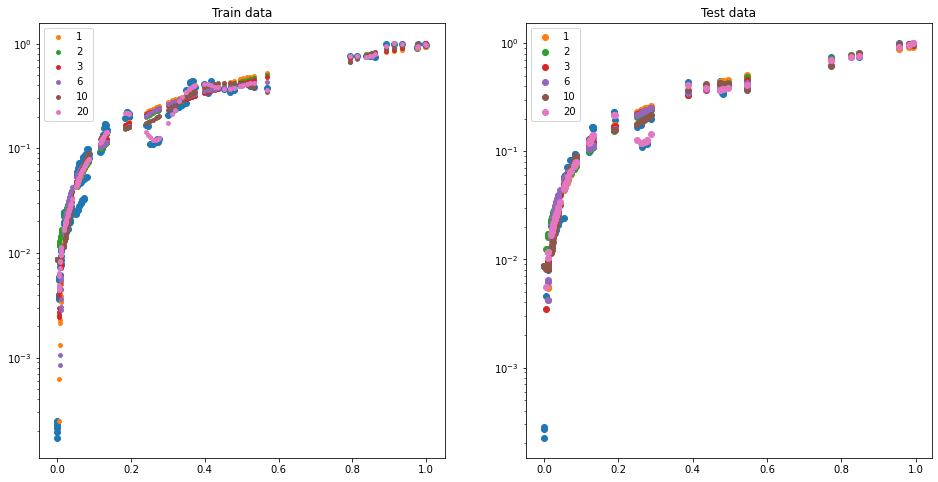

In [11]:
# visualise train and test predictions
# note that the y axis is on a log scale

plt.figure(figsize=(16, 8))

# train data
plt.subplot(121)
plt.scatter(X_train, y_train)
plt.yscale('log')
plt.title("Train data")
for i, degree in enumerate(degrees):    
    plt.scatter(X_train, y_train_pred[:, i], s=15, label=str(degree))
    plt.legend(loc='upper left')
    
# test data
plt.subplot(122)
plt.scatter(X_test, y_test)
plt.yscale('log')
plt.title("Test data")
for i, degree in enumerate(degrees):    
    plt.scatter(X_test, y_test_pred[:, i], label=str(degree))
    plt.legend(loc='upper left')

In [12]:
# compare r2 for train and test sets (for all polynomial fits)
print("R-squared values: \n")

for i, degree in enumerate(degrees):
    train_r2 = round(sklearn.metrics.r2_score(y_train, y_train_pred[:, i]), 2)
    test_r2 = round(sklearn.metrics.r2_score(y_test, y_test_pred[:, i]), 2)
    print("Polynomial degree {0}: train score={1}, test score={2}".format(degree, 
                                                                         train_r2, 
                                                                         test_r2))

R-squared values: 

Polynomial degree 1: train score=0.97, test score=0.95
Polynomial degree 2: train score=0.97, test score=0.97
Polynomial degree 3: train score=0.97, test score=0.97
Polynomial degree 6: train score=0.98, test score=0.97
Polynomial degree 10: train score=0.98, test score=0.98
Polynomial degree 20: train score=0.99, test score=0.99


#### B. Building a Model Without Cross-Validation

In [13]:
# 'furnishingstatus' since we alreday have the dummy vars
Milk_Bovine.drop(['Country'], axis = 1, inplace = True)
Milk_Bovine.head()

,Year,Milk Produced,Number of Dairy Cows
0,2011,3151.00,510.65
1,2011,1126.00,313.18
2,2011,2735.93,374.07
3,2011,4879.50,579.00
4,2011,30301.36,4190.10


I want to compare multiple regression models. First, I will build a vanilla Multiple Linear Regression (MLR) model without any cross-validation

In [14]:
# train-test 70-30 split
df_train, df_test = train_test_split(Milk_Bovine, 
                                     train_size = 0.7, 
                                     test_size = 0.3, 
                                     random_state = 100)

# rescale the features
scaler = MinMaxScaler()

# apply scaler() to all the numeric columns 
numeric_vars = ['Milk Produced', 'Number of Dairy Cows']
df_train[numeric_vars] = scaler.fit_transform(df_train[numeric_vars])
df_train.head()

,Year,Milk Produced,Number of Dairy Cows
154,2016,0.108726,0.125262
97,2014,0.055724,0.058415
273,2021,0.169731,0.129751
200,2018,0.372308,0.453689
132,2015,0.027141,0.031256


In [15]:
# apply rescaling to the test set also
df_test[numeric_vars] = scaler.fit_transform(df_test[numeric_vars])
df_test.head()

,Year,Milk Produced,Number of Dairy Cows
220,2019,0.997442,0.933794
139,2016,0.985130,0.981822
223,2019,0.018712,0.018679
175,2017,0.028934,0.033682
229,2019,0.028358,0.030896


In [16]:
# divide into X_train, y_train, X_test, y_test
y_train = df_train.pop('Milk Produced')
X_train = df_train

y_test = df_test.pop('Milk Produced')
X_test = df_test

#### Using Recursice Feature Elimination (RFE)

In [17]:
# num of max features
len(X_train.columns)

2

In [18]:
# first model with an arbitrary choice of n_features
# running RFE with number of features=10

lm = LinearRegression()
lm.fit(X_train, y_train)

rfe = RFE(lm, n_features_to_select=10)             
rfe = rfe.fit(X_train, y_train)

In [19]:
# tuples of (feature name, whether selected, ranking)
# note that the 'rank' is > 1 for non-selected features
list(zip(X_train.columns,rfe.support_,rfe.ranking_))

[('Year', True, 1), ('Number of Dairy Cows', True, 1)]

In [20]:
# predict prices of X_test
y_pred = rfe.predict(X_test)

# evaluate the model on test set
r2 = sklearn.metrics.r2_score(y_test, y_pred)
print(r2)

0.9781404405453828


In [21]:
# try with another value of RFE
lm = LinearRegression()
lm.fit(X_train, y_train)

rfe = RFE(lm, n_features_to_select=6)             
rfe = rfe.fit(X_train, y_train)

# predict prices of X_test
y_pred = rfe.predict(X_test)
r2 = sklearn.metrics.r2_score(y_test, y_pred)
print(r2)

0.9781404405453828


#### C. Cross Validation

#### C.1. K-Fold CV

In [22]:
# k-fold CV
lm = LinearRegression()
scores = cross_val_score(lm, X_train, y_train, scoring='r2', cv=5)
scores

array([0.94430419, 0.94985908, 0.96462964, 0.91352873, 0.961549  ])

In [23]:
# create a KFold object with 5 splits 
folds = KFold(n_splits = 5, shuffle = True, random_state = 100)
scores = cross_val_score(lm, X_train, y_train, scoring='r2', cv=folds)
scores   

array([0.94725753, 0.96054063, 0.93322491, 0.94406845, 0.96905013])

In [24]:
# tune other metrics, such as MSE
scores = cross_val_score(lm, X_train, y_train, scoring='neg_mean_squared_error', cv=5)
scores

array([-0.00194496, -0.00303835, -0.00125357, -0.001917  , -0.00251077])

#### C.2. Hyperparameter Tuning Using Grid Search Cross Validation

In [25]:
# number of features in X_train
len(X_train.columns)

2

In [26]:
# step-1: create a cross-validation scheme
folds = KFold(n_splits = 5, shuffle = True, random_state = 100)

# step-2: specify range of hyperparameters to tune
hyper_params = [{'n_features_to_select': list(range(1, 14))}]


# step-3: perform grid search
# 3.1 specify model
lm = LinearRegression()
lm.fit(X_train, y_train)
rfe = RFE(lm)             

# 3.2 call GridSearchCV()
model_cv = GridSearchCV(estimator = rfe, 
                        param_grid = hyper_params, 
                        scoring= 'r2', 
                        cv = folds, 
                        verbose = 1,
                        return_train_score=True)      

# fit the model
model_cv.fit(X_train, y_train)                  


Fitting 5 folds for each of 13 candidates, totalling 65 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=100, shuffle=True),
             estimator=RFE(estimator=LinearRegression()),
             param_grid=[{'n_features_to_select': [1, 2, 3, 4, 5, 6, 7, 8, 9,
                                                   10, 11, 12, 13]}],
             return_train_score=True, scoring='r2', verbose=1)

In [27]:
# cv results
cv_results = pd.DataFrame(model_cv.cv_results_)
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_features_to_select,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.001601,0.003202,0.001640,0.003281,1,{'n_features_to_select': 1},0.950646,0.960653,0.929022,0.943457,...,0.950843,0.014219,1,0.951948,0.949533,0.958998,0.952447,0.947161,0.952017,0.003967
1,0.001606,0.003213,0.000000,0.000000,2,{'n_features_to_select': 2},0.947258,0.960541,0.933225,0.944068,...,0.950828,0.012607,2,0.955467,0.952284,0.959323,0.954912,0.950193,0.954436,0.003092
2,0.001620,0.003240,0.001640,0.003279,3,{'n_features_to_select': 3},0.947258,0.960541,0.933225,0.944068,...,0.950828,0.012607,2,0.955467,0.952284,0.959323,0.954912,0.950193,0.954436,0.003092
3,0.001603,0.003206,0.000000,0.000000,4,{'n_features_to_select': 4},0.947258,0.960541,0.933225,0.944068,...,0.950828,0.012607,2,0.955467,0.952284,0.959323,0.954912,0.950193,0.954436,0.003092
4,0.000000,0.000000,0.000000,0.000000,5,{'n_features_to_select': 5},0.947258,0.960541,0.933225,0.944068,...,0.950828,0.012607,2,0.955467,0.952284,0.959323,0.954912,0.950193,0.954436,0.003092
5,0.001599,0.003199,0.001599,0.003199,6,{'n_features_to_select': 6},0.947258,0.960541,0.933225,0.944068,...,0.950828,0.012607,2,0.955467,0.952284,0.959323,0.954912,0.950193,0.954436,0.003092
6,0.003199,0.003918,0.000000,0.000000,7,{'n_features_to_select': 7},0.947258,0.960541,0.933225,0.944068,...,0.950828,0.012607,2,0.955467,0.952284,0.959323,0.954912,0.950193,0.954436,0.003092
7,0.001599,0.003199,0.000000,0.000000,8,{'n_features_to_select': 8},0.947258,0.960541,0.933225,0.944068,...,0.950828,0.012607,2,0.955467,0.952284,0.959323,0.954912,0.950193,0.954436,0.003092
8,0.001599,0.003198,0.000000,0.000000,9,{'n_features_to_select': 9},0.947258,0.960541,0.933225,0.944068,...,0.950828,0.012607,2,0.955467,0.952284,0.959323,0.954912,0.950193,0.954436,0.003092
9,0.001600,0.003199,0.001599,0.003198,10,{'n_features_to_select': 10},0.947258,0.960541,0.933225,0.944068,...,0.950828,0.012607,2,0.955467,0.952284,0.959323,0.954912,0.950193,0.954436,0.003092


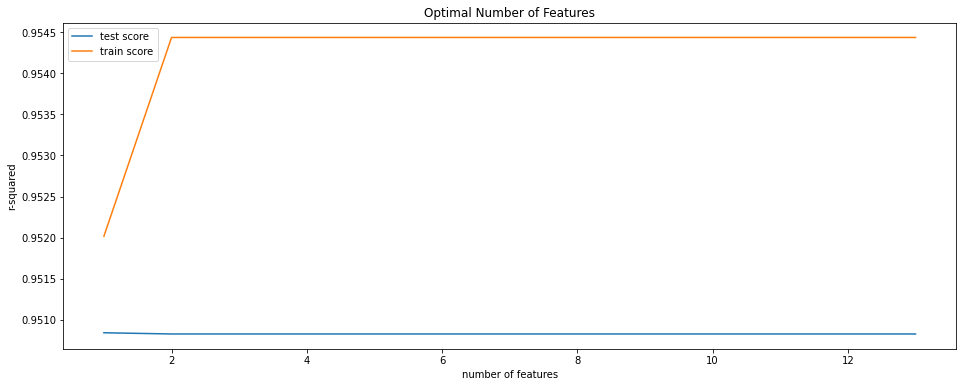

In [28]:
# plotting cv results
plt.figure(figsize=(16,6))

plt.plot(cv_results["param_n_features_to_select"], cv_results["mean_test_score"])
plt.plot(cv_results["param_n_features_to_select"], cv_results["mean_train_score"])
plt.xlabel('number of features')
plt.ylabel('r-squared')
plt.title("Optimal Number of Features")
plt.legend(['test score', 'train score'], loc='upper left')

In [29]:
# final model
n_features_optimal = 10

lm = LinearRegression()
lm.fit(X_train, y_train)

rfe = RFE(lm, n_features_to_select=n_features_optimal)             
rfe = rfe.fit(X_train, y_train)

# predict prices of X_test
y_pred = lm.predict(X_test)
r2 = sklearn.metrics.r2_score(y_test, y_pred)
print(r2)

0.9781404405453828


Notice that the test score is very close to the 'mean test score'.

## Comparison of Machine Learning Models

In [30]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import itertools
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from mlxtend.classifier import EnsembleVoteClassifier
from mlxtend.data import iris_data
from mlxtend.plotting import plot_decision_regions

# Initializing Classifiers
clf1 = LogisticRegression(random_state=0)
clf2 = RandomForestClassifier(random_state=0)
clf3 = SVC(random_state=0, probability=True)
eclf = EnsembleVoteClassifier(clfs=[clf1, clf2, clf3], weights=[2, 1, 1], voting='soft')

# Loading some example data
X, y = Milk_Bovine()
X = X[:,[0, 2]]

# Plotting Decision Regions
gs = gridspec.GridSpec(2, 2)
fig = plt.figure(figsize=(10, 8))

for clf, lab, grd in zip([clf1, clf2, clf3, eclf],
                         ['Logistic Regression', 'Random Forest', 'RBF kernel SVM', 'Ensemble'],
                         itertools.product([0, 1], repeat=2)):
    clf.fit(X, y)
    ax = plt.subplot(gs[grd[0], grd[1]])
    fig = plot_decision_regions(X=X, y=y, clf=clf, legend=2)
    plt.title(lab)
plt.show()

ModuleNotFoundError: No module named 'mlxtend'